In [1]:
using Plots; gr(legend=true,dpi=800); 
using LinearAlgebra
using BenchmarkTools
using Printf
using Revise
using DifferentialDynamicProgramming

In [6]:
# make stable linear dynamics
h = .01         # time step
n = 10          # state dimension
m = 2           # control dimension
A = randn(n,n)
A = A-A'        # skew-symmetric = pure imaginary eigenvalues
A = exp(h*A)    # discrete time
B = h*randn(n,m)

# quadratic costs
Q    = h*I + zeros(n,n)
R    = .1*h*I + zeros(m,m)

# control limits
lims = [] #ones(m,1)*[-1 1]*.6

T    = 1000             # horizon
x0   = ones(n,1)        # initial state
u0   = .1*randn(m,T)    # initial controls

# optimization problem
N    = T+1
fx   = A
fu   = B
cxx  = Q
cxu  = zeros(size(B))
cuu  = R

# Specify dynamics functions
function lin_dyn_df(x::Vector,u::Vector,Q::Matrix,R::Matrix)
    u[isnan(u)] = 0
    cx  = Q*x
    cu  = R*u
    fxx=fxu=fuu = []
    return fx,fu,fxx,fxu,fuu,cx,cu,cxx,cxu,cuu
end

function lin_dyn_f(x::Vector{Float64},u::Vector{Float64},A::Matrix{Float64},B::Matrix{Float64})
    u[isnan(u)] = 0
    xnew = A*x + B*u
    return xnew
end

function lin_dyn_cost(x,u,Q)
    c = 0.5*sum(x.*(Q*x)) + 0.5*sum(u.*(R*u))
    return c
end

f(x,u,i)     = lin_dyn_f(x,u,A,B,Q,R)
costfun(x,u) = lin_dyn_cost(x,u,Q)
df(x,u)      = lin_dyn_df(x,u,Q,R)

# run the optimization

@time x, u, L, Vx, Vxx, cost, otrace = iLQG(f, costfun ,df, x0, u0, lims=lims);

MethodError: MethodError: no method matching lin_dyn_f(::Vector{Float64}, ::Vector{Float64}, ::Matrix{Float64}, ::Matrix{Float64}, ::Matrix{Float64}, ::Matrix{Float64})
Closest candidates are:
  lin_dyn_f(::Vector{Float64}, ::Vector{Float64}, ::Matrix{Float64}, ::Matrix{Float64}) at ~/Dropbox (GaTech)/Dropbox_Tomo/github/CDDP.jl/notebooks/test_ddp.ipynb:38
  lin_dyn_f(::Vector, ::Vector, ::Matrix, ::Matrix) at ~/Dropbox (GaTech)/Dropbox_Tomo/github/CDDP.jl/notebooks/test_ddp.ipynb:38
  lin_dyn_f(::Any, ::Any, ::Any, ::Any) at ~/Dropbox (GaTech)/Dropbox_Tomo/github/CDDP.jl/notebooks/test_ddp.ipynb:38
  ...

In [12]:
using ControlSystems
using Plots
using LinearAlgebra

In [10]:
function lqr(A, B, Q, R)
    S = care(A, B, Q, R)
    K = R\B'*S
    return K
end

lqr (generic function with 1 method)

In [24]:
x0 = [π-0.6,0,0,0]
goal = [π,0,0,0]
Q      = Diagonal([10.,1,2,1]) # State weight matrix
R      = 1.                    # Control weight matrixf
lims   = 5.0*[-1 1]            # control limits,
T      = 600                   # Number of time steps
doplot = true                   # Plot results

N = T+1
g = 9.82
l = 0.35 # Length of pendulum
h = 0.01 # Sample time
d = 0.99
A = [0 1 0 0; # Linearlized system dynamics matrix, continuous time
g/l -d 0 0;
0 0 0 1;
0 0 0 0]
B = [0, -1/l, 0, 1]
C = I + zeros(4,4) # Assume all states are measurable
D = 4
L = lqr(A,B,Q,R) # Calculate the optimal state feedback


function fsys_closedloop(t,x,L,xd)
    dx = copy(x)
    dx[1] -= pi
    u = -(L*dx)[1]
    xd[1] = x[2]
    xd[2] = -g/l * sin(x[1]) + u/l * cos(x[1]) - d*x[2]
    xd[3] = x[4]
    xd[4] = u
end

function fsys(t,x,u,xd)
    xd[1] = x[2]
    xd[2] = -g/l * sin(x[1]) + u/l * cos(x[1]) - d*x[2]
    xd[3] = x[4]
    xd[4] = u
end

dfvec = zeros(4)
function dfsys(x,u)
    dfvec[1] = x[1]+h*x[2]
    dfvec[2] = x[2]+h*(-g/l*sin(x[1])+u[1]/l*cos(x[1])- d*x[2])
    dfvec[3] = x[3]+h*x[4]
    dfvec[4] = x[4]+h*u[1]
    dfvec
end


function cost_quadratic(x,u)
    local d = (x.-goal)
    0.5(d'*Q*d + u'R*u)[1]
end

function cost_quadratic(x::Matrix,u)
    local d = (x.-goal)
    T = size(u,2)
    c = Vector{Float64}(undef,T+1)
    for t = 1:T
        c[t] = 0.5(d[:,t]'*Q*d[:,t] + u[:,t]'R*u[:,t])[1]
    end
    c[end] = cost_quadratic(x[:,end][:],[0.0])
    return c
end

cx = zeros(4,T)
cu = zeros(1,T)
cxu = zeros(D,1)

function dcost_quadratic(x,u)
    cx  .= Q*(x.-goal)
    cu  .= R.*u
    return cx,cu,cxu
end


function lin_dyn_f(x,u,i)
    u[isnan.(u)] .= 0
    f = dfsys(x,u)
end


fxc           = Array{Float64}(undef,D,D,T)
fuc           = Array{Float64}(undef,D,1,T)
fxd           = Array{Float64}(undef,D,D,T)
fud           = Array{Float64}(undef,D,1,T)
for ii = 1:T
    fxc[:,:,ii] = [0 1 0 0;
    0 0 0 0;
    0 0 0 1;
    0 0 0 0]
    fuc[:,:,ii] = [0, 0, 0, 1]
end

function lin_dyn_df(x,u)
    u[isnan.(u)] .= 0
    D            = size(x,1)
    nu,I         = size(u)
    cx,cu,cxu    = dcost_quadratic(x,u)
    cxx          = Q
    cuu          = [R]
    for ii = 1:I
        fxc[2,1,ii] = -g/l*cos(x[1,ii])-u[ii]/l*sin(x[1,ii])
        fxc[2,2,ii] = -d
        fuc[2,1,ii] = cos(x[1,ii])/l
        ABd = exp([fxc[:,:,ii]*h  fuc[:,:,ii]*h; zeros(nu, D + nu)])# ZoH sampling
        fxd[:,:,ii] = ABd[1:D,1:D]
        fud[:,:,ii] = ABd[1:D,D+1:D+nu]
    end
    fxx=fxu=fuu = []
    return fxd,fud,fxx,fxu,fuu,cx,cu,cxx,cxu,cuu
end

x = zeros(4,N)
u = zeros(1,T)

"""
Simulate a pendulum on a cart using the non-linear equations
"""
function simulate_pendcart(x0,L, dfsys, cost)
    x[:,1] = x0
    u[1] = 0
    for t = 2:T
        dx     = copy(x[:,t-1])
        dx[1] -= pi
        u[t]   = -(L*dx)[1]
        if !isempty(lims)
            u[t]   = clamp(u[t],lims[1],lims[2])
        end
        x[:,t] = dfsys(x[:,t-1],u[t])
    end
    dx      = copy(x[:,T])
    dx[1]  -= pi
    uT      = -(L*dx)[1]
    if !isempty(lims)
        uT   = clamp(uT,lims[1],lims[2])
    end
    x[:,T+1] = dfsys(x[:,T],uT)
    c = cost(x,u)

    return x, u, c
end


plotstuff_pendcart(args...) = println("Install package Plots.jl (and call using Plots) to plot results in the end of demo_pendcart")



# Simulate the closed loop system with regular LQG control and watch it fail due to control limits
x00, u00, cost00 = simulate_pendcart(x0, L, dfsys, cost_quadratic)

f(x,u,i) = lin_dyn_f(x,u,i)
df(x,u)  = lin_dyn_df(x,u)
# plotFn(x)  = plot(squeeze(x,2)')

println("Entering iLQG function")
# subplot(n=4,nc=2)
x, u, L, Vx, Vxx, cost, trace = iLQG(f,cost_quadratic, df, x0, 0*u00,
lims      = lims,
# plotFn  = x -> Plots.subplot!(x'),
regType   = 2,
α         = exp10.(range(0.2, stop=-3, length=6)),
λmax      = 1e15,
verbosity = 3,
tol_fun   = 1e-8,
tol_grad   = 1e-8,
max_iter  = 1000);

doplot && plotstuff_pendcart(x00, u00, x,u,cost00,cost,trace)
println("Done")


Entering iLQG function



---------- begin iLQG ----------
iteration     cost    reduction     expected    gradient    log10(λ)    η    divergence


1           33409.7     2.21e+03    3.57e+03    2.35        0.0         
2           31195       705         1.57e+03    0.7         -0.2        
3           30489.9     537         1.82e+03    0.719       -0.6        
4           29952.6     13.9        479         0.406       -1.2        
5           29938.7     224         896         0.427       -2.0        
6           29714.5     257         260         0.254       -3.1        


7           29457.7     10.2        86.3        0.159       -4.3        
8           29447.5     79.8        90.3        0.16        -5.7        
9           29367.7     18.1        20.4        0.0844      -7.3        
10          29349.5     4.78        5.23        0.0469      -9.2        


iteration     cost    reduction     expected    gradient    log10(λ)    η    divergence
11          29344.8     0.633       1.81        0.027       -11.2       
12          29344.1     1.25        1.62        0.0218      -13.5       
13          29342.9     1.38        2.12        0.0204      -15.9       


14          29341.5     0.221       0.471       0.0109      -18.6       
15          29341.3     0.0322      0.111       0.00601     -21.4       


16          29341.2     0.0121      0.0284      0.00338     -24.5       
17          29341.2     0.0289      0.00881     0.00194     -27.8       
18          29341.2     0.146       0.00967     0.00162     -31.2       
19          NO STEP     -8.15e-05   4.49e-05    0.00151     -6.0        
20          NO STEP     -8.15e-05   4.49e-05    0.00151     -5.8        
iteration     cost    reduction     expected    gradient    log10(λ)    η    divergence


21          NO STEP     -8.15e-05   4.49e-05    0.00151     -5.4        
22          NO STEP     -8.15e-05   4.49e-05    0.00151     -4.8        
23          NO STEP     -8.15e-05   4.49e-05    0.00151     -4.0        
24          NO STEP     -8.15e-05   4.49e-05    0.00151     -2.9        
25          NO STEP     -8.15e-05   4.49e-05    0.00151     -1.7        
26          NO STEP     -8.15e-05   4.49e-05    0.00151     -0.3        


27          NO STEP     -8.1e-05    4.49e-05    0.00151     1.3         
28          NO STEP     -6.37e-05   4.28e-05    0.00142     3.2         
29          29341       0.0181      0.00494     0.000294    3.2         
30          29341       0.0108      0.00163     0.000587    3.0         
iteration     cost    reduction     expected    gradient    log10(λ)    η    divergence
31          29341       0.0124      0.00142     0.000705    2.6         


32          NO STEP     -1.52e-05   4.11e-06    0.000713    1.3         
33          NO STEP     -3.25e-05   8.4e-06     0.00108     1.6         
34          NO STEP     -2.93e-05   7.42e-06    0.000994    2.0         
35          NO STEP     -1.52e-05   4.11e-06    0.000713    2.6         
36          29341       0.000673    0.00041     0.000329    2.6         
37          NO STEP     -4.48e-06   1.01e-06    0.000377    2.2         


38          NO STEP     -1.02e-05   1.94e-06    0.000507    2.4         
39          NO STEP     -4.48e-06   1.01e-06    0.000377    2.8         
40          NO STEP     -6.86e-07   2.39e-07    0.000187    3.4         
iteration     cost    reduction     expected    gradient    log10(λ)    η    divergence
41          NO STEP     -7.03e-08   2.96e-08    5.16e-05    4.2         
42          NO STEP     -1.17e-09   2.86e-09    8.09e-06    5.2         
43          29341       5.78e-07    3.77e-07    7.76e-07    5.2         
44          29341       5.64e-07    6e-07       1.24e-06    5.0         


45          NO STEP     -1.6e-10    1.02e-09    3.16e-06    4.2         
46          NO STEP     -2.84e-09   2.84e-09    8.08e-06    4.4         
47          NO STEP     -9.24e-10   1.69e-09    5.06e-06    4.8         
48          29341       1.43e-07    9.56e-07    1.98e-06    4.8         


49          NO STEP     -7.86e-10   1.01e-09    3.16e-06    4.4         
50          NO STEP     -1.82e-09   1.68e-09    5.05e-06    4.6         
iteration     cost    reduction     expected    gradient    log10(λ)    η    divergence
51          NO STEP     -7.86e-10   1.01e-09    3.16e-06    5.0         
52          NO STEP     -1.31e-10   3.82e-10    1.23e-06    5.6         
53          NO STEP     -7.28e-12   9.15e-11    3.01e-07    6.5         


54          29341       2.36e-10    2.2e-08     4.6e-08     6.5         

SUCCESS: cost change < tol_fun

 iterations:   54 

        final cost:   29341       

        final grad:   4.599734e-08

        final λ: 1.7668471e+06

        time / iter:  28    ms

        total time:   1.49  seconds, of which

        derivs:     16.4%

        back pass:  45.9%

        fwd pass:   37.0%

        other:      0.7 % (graphics etc.)
 =========== end iLQG ===========
Install package Plots.jl (and call using Plots) to plot results in the end of demo_pendcart
Done


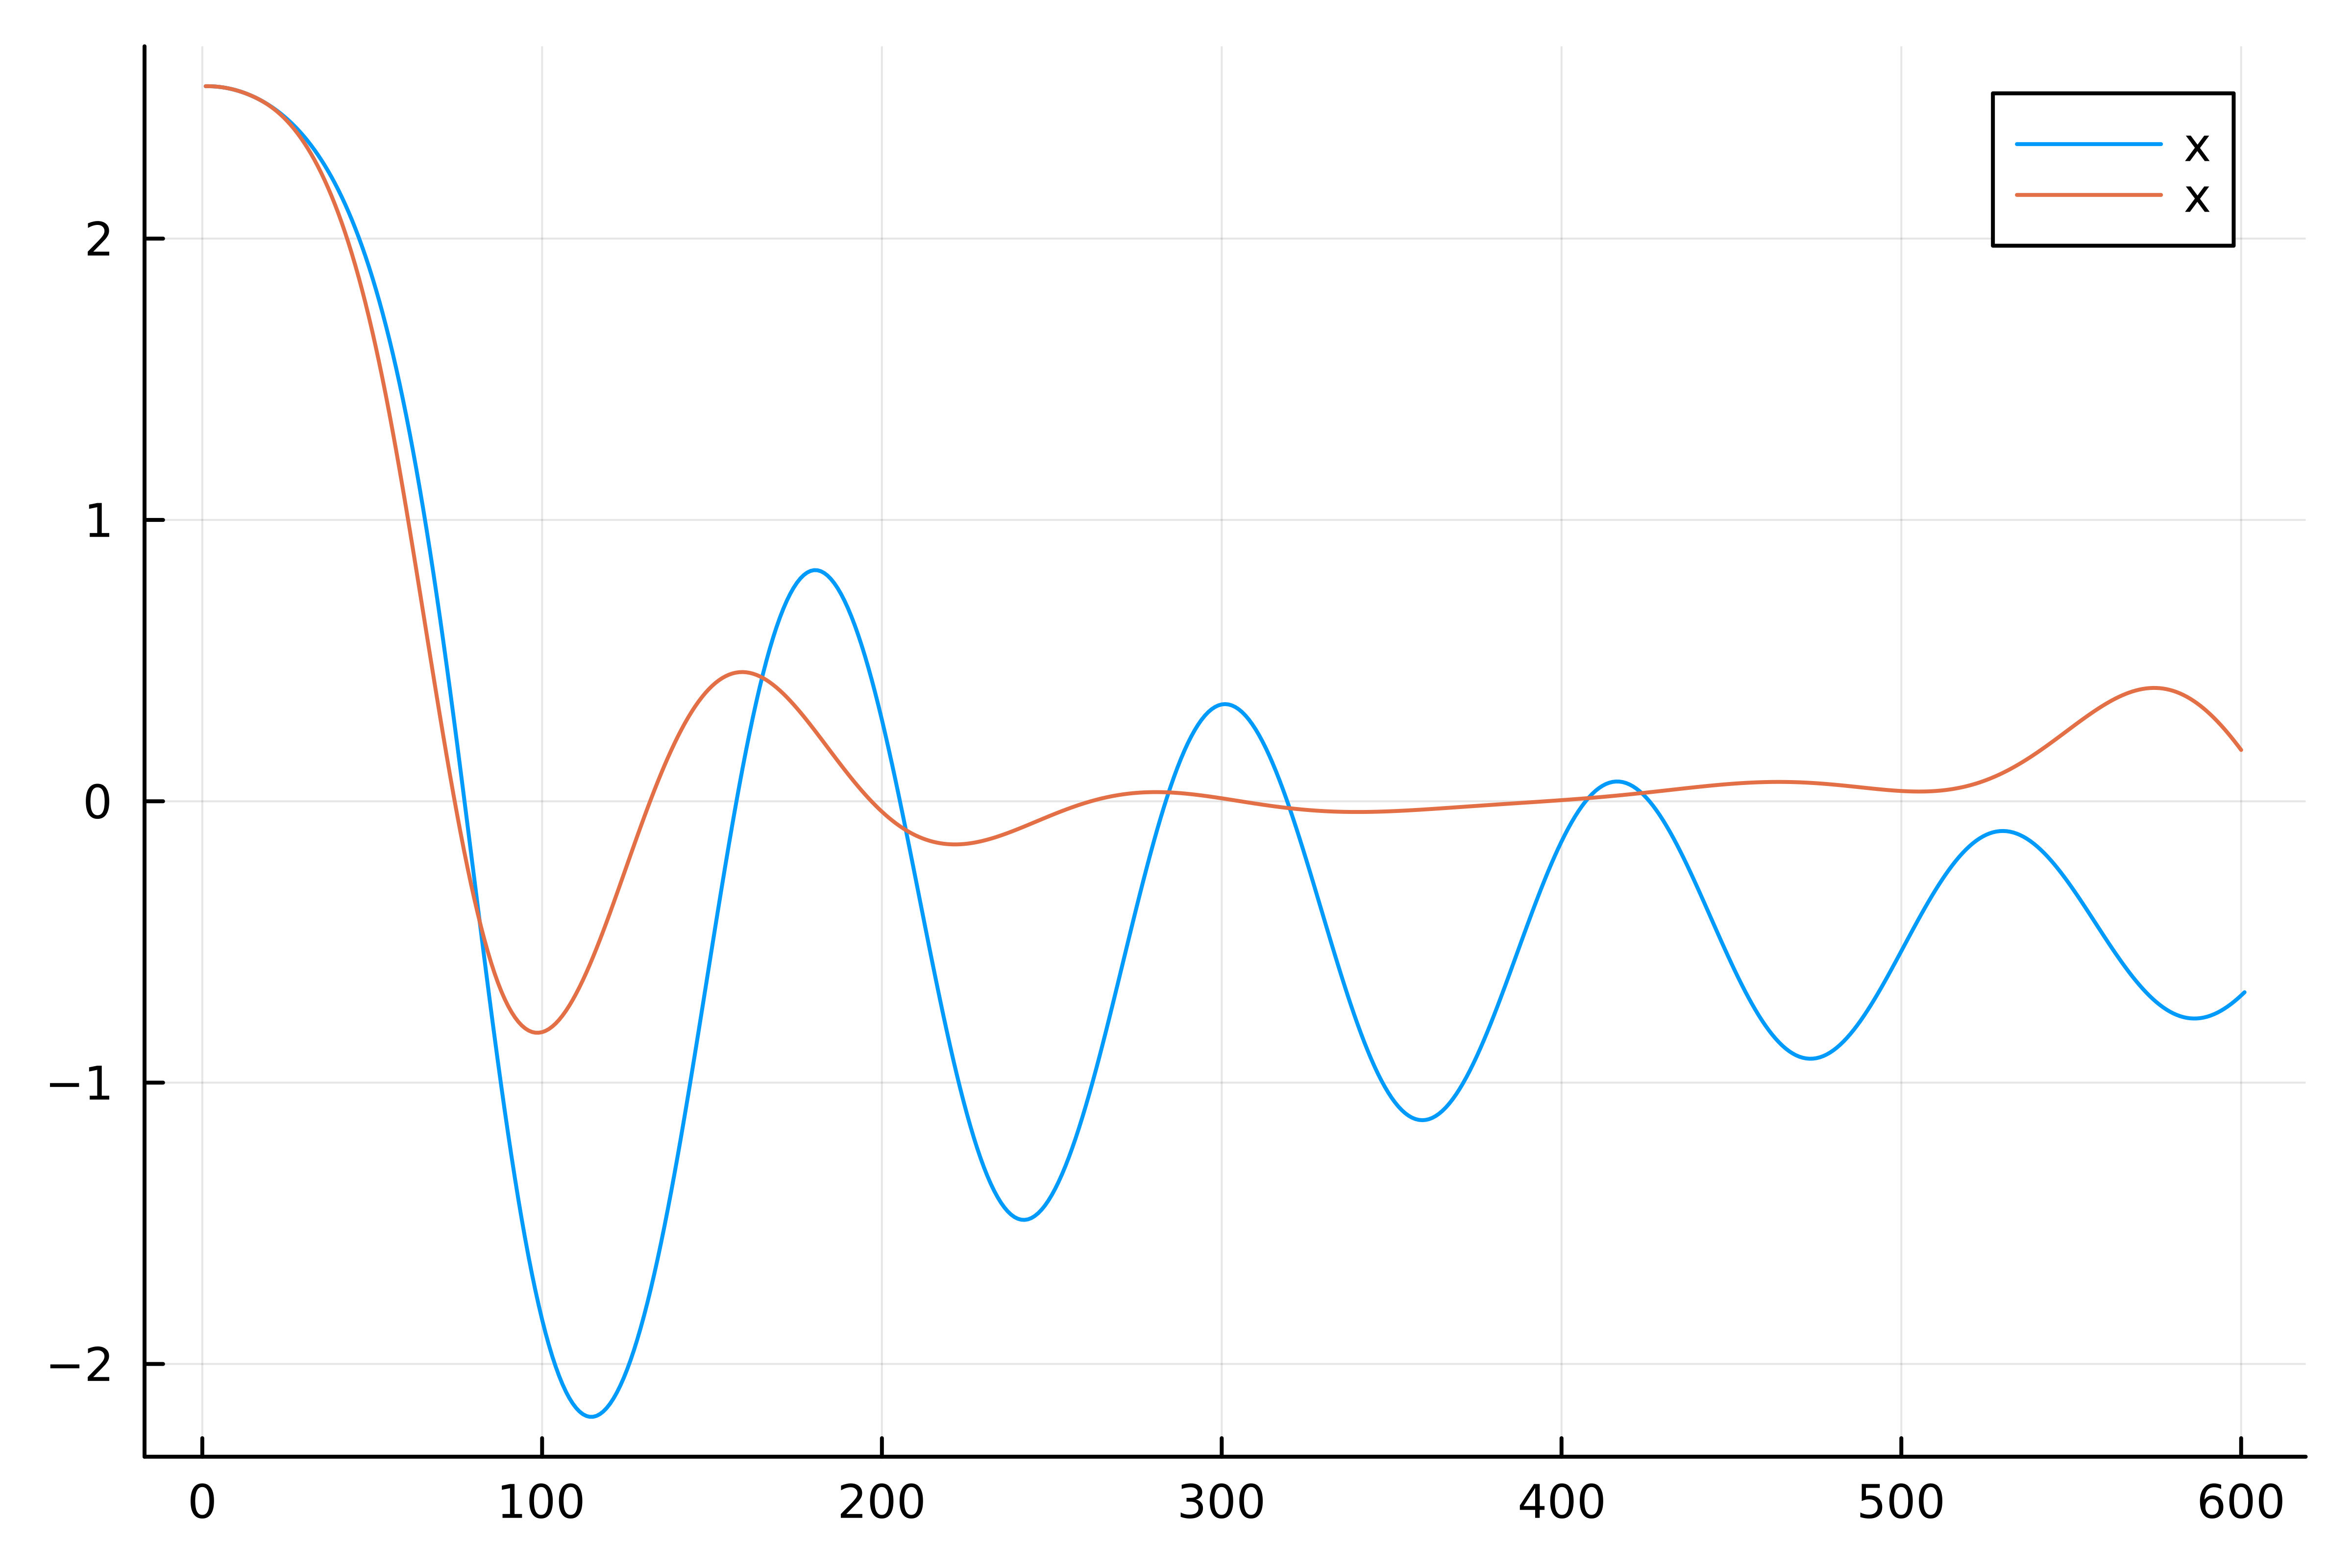

In [25]:
plot(x00[1,:], label="x")
plot!(x[1,:], label="x")

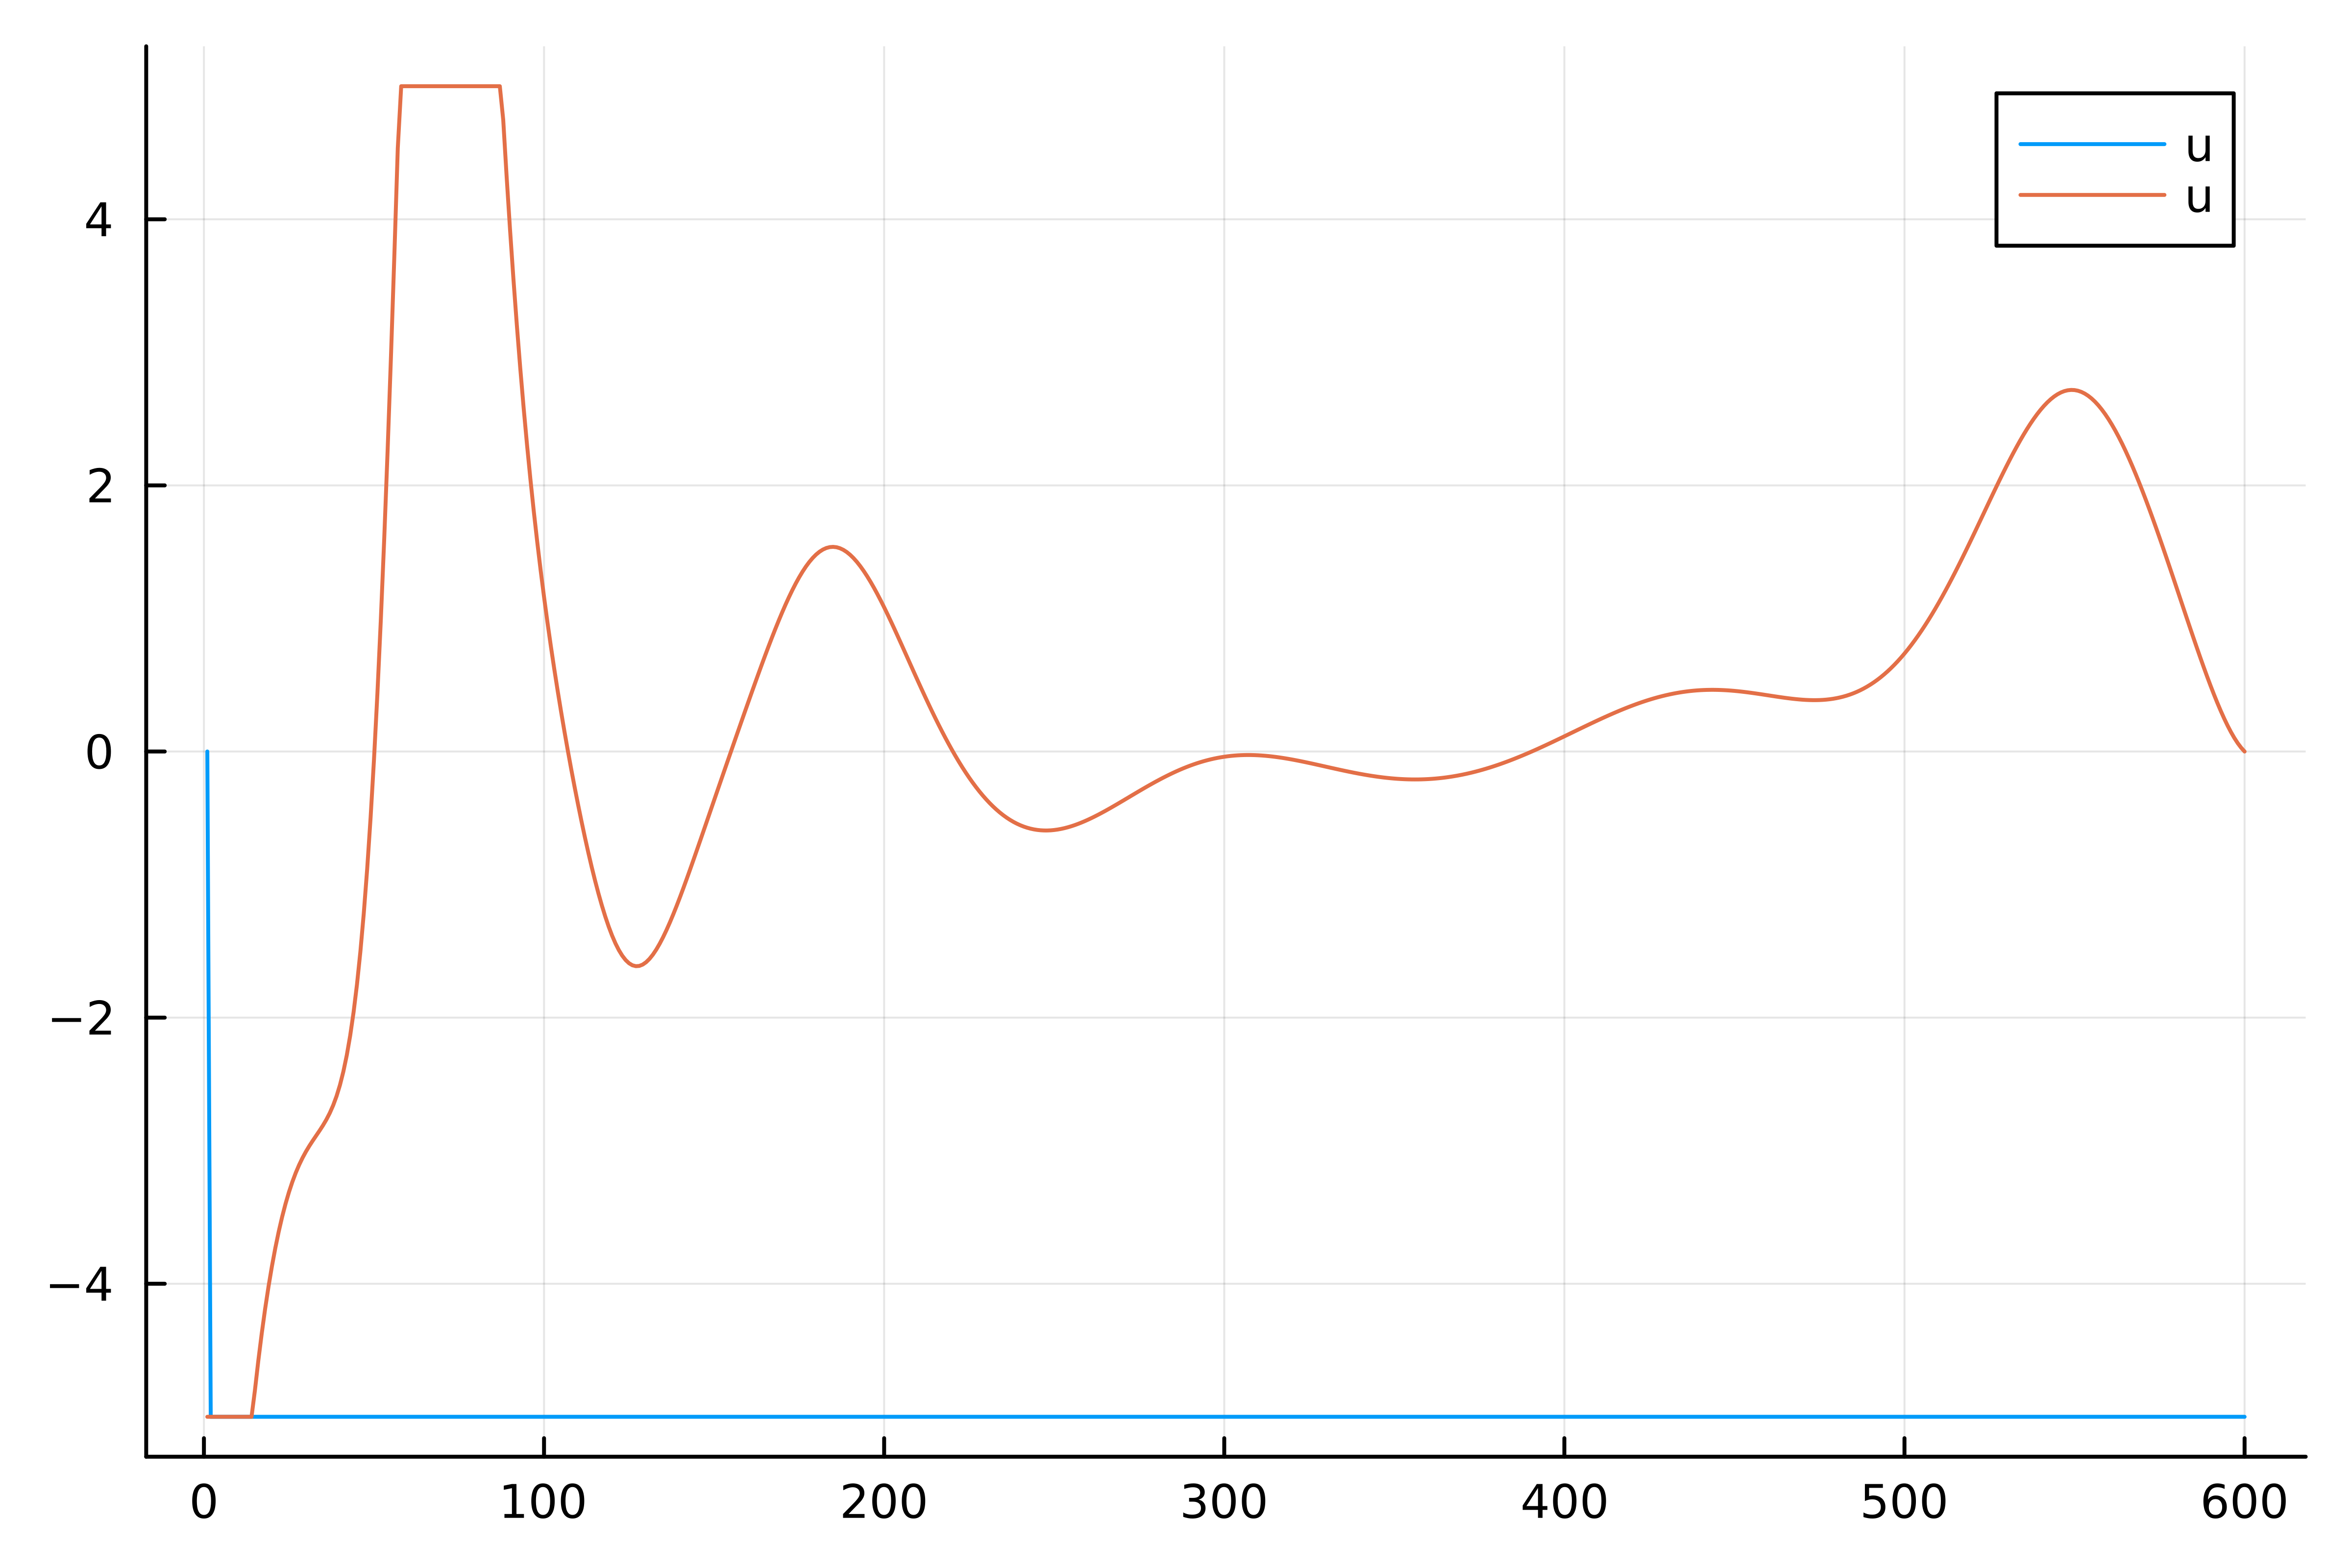

In [26]:
plot(u00[1,:], label="u")
plot!(u[1,:], label="u")